In [5]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [81]:
import numpy as np
import glob
from PIL import Image
from matplotlib.pyplot import imshow
import keras
from keras import layers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

def get_images(path,resize = True):  
    img_array = []
    label_array=[]
    img_paths=[]
    fpaths = glob.glob(path, recursive=True)
    
    for fname in fpaths:
        img = Image.open(fname)#.convert('L')
        if(resize): img = img.resize((256,256))
        img_array.append(np.asarray(img))
        img_paths.append(fname)
        
        if 'good' in fname.split("/"):
            label_array.append(0)
        else:
            label_array.append(1)
            
    paths=np.array(img_paths)
    images = np.array(img_array)
    labels= np.array(label_array)
    return images,labels,paths


In [82]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size=(3, 3), stride=(1, 1)):

        super(ResidualBlock, self).__init__()

        self.residual_block = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size,
                                   strides=stride, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size,
                                   strides=stride, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.2),
        ])

    def call(self, x, **kwargs):
        return x + self.residual_block(x)


class ResNetEncoder(tf.keras.models.Model):
    def __init__(self,
                 n_ResidualBlock=8,
                 n_levels=4,
                 z_dim=10,
                 bUseMultiResSkips=True):

        super(ResNetEncoder, self).__init__()

        self.max_filters = 2 ** (n_levels+3)
        self.n_levels = n_levels
        self.bUseMultiResSkips = bUseMultiResSkips

        self.conv_list = []
        self.res_blk_list = []
        self.multi_res_skip_list = []

        self.input_conv = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3),
                                   strides=(1, 1), padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.2),
        ])

        for i in range(n_levels):
            n_filters_1 = 2 ** (i + 3)
            n_filters_2 = 2 ** (i + 4)
            ks = 2 ** (n_levels - i)

            self.res_blk_list.append(
                tf.keras.Sequential([ResidualBlock(n_filters_1)
                                     for _ in range(n_ResidualBlock)])
            )

            self.conv_list.append(
                tf.keras.Sequential([
                    tf.keras.layers.Conv2D(filters=n_filters_2, kernel_size=(2, 2),
                                           strides=(2, 2), padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.LeakyReLU(alpha=0.2),
                ])
            )

            if bUseMultiResSkips:
                self.multi_res_skip_list.append(
                    tf.keras.Sequential([
                        tf.keras.layers.Conv2D(filters=self.max_filters, kernel_size=(ks, ks),
                                               strides=(ks, ks), padding='same'),
                        tf.keras.layers.BatchNormalization(),
                        tf.keras.layers.LeakyReLU(alpha=0.2),
                    ])
                )

        self.output_conv = tf.keras.layers.Conv2D(filters=z_dim, kernel_size=(3, 3),
                                                  strides=(1, 1), padding='same')

    def call(self, x, **kwargs):

        x = self.input_conv(x)

        skips = []
        for i in range(self.n_levels):
            x = self.res_blk_list[i](x)
            if self.bUseMultiResSkips:
                skips.append(self.multi_res_skip_list[i](x))
            x = self.conv_list[i](x)

        if self.bUseMultiResSkips:
            x = sum([x] + skips)

        x = self.output_conv(x)

        return x


class ResNetDecoder(tf.keras.models.Model):
    def __init__(self,
                 n_ResidualBlock=8,
                 n_levels=4,
                 output_channels=3,
                 bUseMultiResSkips=True):

        super(ResNetDecoder, self).__init__()

        self.max_filters = 2 ** (n_levels+3)
        self.n_levels = n_levels
        self.bUseMultiResSkips = bUseMultiResSkips

        self.conv_list = []
        self.res_blk_list = []
        self.multi_res_skip_list = []

        self.input_conv = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=self.max_filters, kernel_size=(3, 3),
                                   strides=(1, 1), padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.2),
        ])

        for i in range(n_levels):
            n_filters = 2 ** (self.n_levels - i + 2)
            ks = 2 ** (i + 1)

            self.res_blk_list.append(
                tf.keras.Sequential([ResidualBlock(n_filters)
                                     for _ in range(n_ResidualBlock)])
            )

            self.conv_list.append(
                tf.keras.Sequential([
                    tf.keras.layers.Conv2DTranspose(filters=n_filters, kernel_size=(2, 2),
                                                    strides=(2, 2), padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.LeakyReLU(alpha=0.2),
                ])
            )

            if bUseMultiResSkips:
                self.multi_res_skip_list.append(
                    tf.keras.Sequential([
                        tf.keras.layers.Conv2DTranspose(filters=n_filters, kernel_size=(ks, ks),
                                                        strides=(ks, ks), padding='same'),
                        tf.keras.layers.BatchNormalization(),
                        tf.keras.layers.LeakyReLU(alpha=0.2),
                    ])
                )

        self.output_conv = tf.keras.layers.Conv2D(filters=output_channels, kernel_size=(3, 3),
                                                  strides=(1, 1), padding='same')

    def call(self, z, **kwargs):

        z = z_top = self.input_conv(z)

        for i in range(self.n_levels):
            z = self.conv_list[i](z)
            z = self.res_blk_list[i](z)
            if self.bUseMultiResSkips:
                z += self.multi_res_skip_list[i](z_top)

        z = self.output_conv(z)

        return z


class ResNetAE(tf.keras.models.Model):
    def __init__(self,
                 input_shape=(256, 256, 3),
                 n_ResidualBlock=8,
                 n_levels=4,
                 z_dim=128,
                 bottleneck_dim=128,
                 bUseMultiResSkips=True):
        super(ResNetAE, self).__init__()

        assert input_shape[0] == input_shape[1]
        output_channels = input_shape[2]
        self.z_dim = z_dim
        self.img_latent_dim = input_shape[0] // (2 ** n_levels)

        self.encoder = ResNetEncoder(n_ResidualBlock=n_ResidualBlock, n_levels=n_levels,
                                     z_dim=z_dim, bUseMultiResSkips=bUseMultiResSkips)
        self.decoder = ResNetDecoder(n_ResidualBlock=n_ResidualBlock, n_levels=n_levels,
                                     output_channels=output_channels, bUseMultiResSkips=bUseMultiResSkips)

        self.fc1 = tf.keras.layers.Dense(bottleneck_dim)
        self.fc2 = tf.keras.layers.Dense(self.img_latent_dim * self.img_latent_dim * self.z_dim)

    def encode(self, x):
        h = self.encoder(x)
        h = tf.keras.backend.reshape(h, shape=(-1, self.img_latent_dim * self.img_latent_dim * self.z_dim))
        return self.fc1(h)

    def decode(self, z):
        z = self.fc2(z)
        z = tf.keras.backend.reshape(z, shape=(-1, self.img_latent_dim, self.img_latent_dim, self.z_dim))
        h = self.decoder(z)
        return tf.keras.backend.sigmoid(h)

    def call(self, x, **kwargs):
        
        
        return self.decode(self.encode(x))
    

In [86]:
path_train = r"/content/drive/MyDrive/data/good/*.*"
path_test = r"/content/drive/MyDrive/data/test/**/*.*"
path_cont_test = r"/content/drive/MyDrive/data/test/contamination/*.*"
all_train,train_labels ,train_paths= get_images(path_train)
test ,test_labels,test_paths= get_images(path_test)
cont_test ,cont_test_labels,cont_test_paths= get_images(path_cont_test)
all_train = all_train.astype('float32') /255.
test = test.astype('float32') / 255.
cont_test = cont_test.astype('float32') / 255.
(train, val) = train_test_split(all_train, shuffle=False, train_size=0.8, random_state=1)
train = train.reshape(train.shape[0], train.shape[1], train.shape[2], 3)
val = val.reshape(val.shape[0], val.shape[1], val.shape[2], 3)
test = test.reshape(test.shape[0], test.shape[1], test.shape[2], 3)
cont_test = cont_test.reshape(cont_test.shape[0], cont_test.shape[1], cont_test.shape[2], 3)
autoencoder = ResNetAE()

autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])

es_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
epochs=25
autoencoder_train=autoencoder.fit(train, train,
            epochs=epochs,
            batch_size=20,
            shuffle=True,
            validation_data=(val,val),
            callbacks=[es_callback])
print(autoencoder.summary())

Epoch 1/25
9/9 [==============================] - 41s 2s/step - loss: 0.2458 - mae: 0.3981 - val_loss: 0.3760 - val_mae: 0.4946
Epoch 2/25
9/9 [==============================] - 16s 2s/step - loss: 0.0872 - mae: 0.2300 - val_loss: 0.3773 - val_mae: 0.4960
Epoch 3/25
9/9 [==============================] - 16s 2s/step - loss: 0.0354 - mae: 0.1368 - val_loss: 0.3599 - val_mae: 0.5110
Epoch 4/25
9/9 [==============================] - 16s 2s/step - loss: 0.0185 - mae: 0.0822 - val_loss: 0.3534 - val_mae: 0.4816
Epoch 5/25
9/9 [==============================] - 16s 2s/step - loss: 0.0127 - mae: 0.0627 - val_loss: 0.1046 - val_mae: 0.2195
Epoch 6/25
9/9 [==============================] - 16s 2s/step - loss: 0.0096 - mae: 0.0537 - val_loss: 0.0602 - val_mae: 0.1782
Epoch 7/25
9/9 [==============================] - 16s 2s/step - loss: 0.0075 - mae: 0.0471 - val_loss: 0.0482 - val_mae: 0.1639
Epoch 8/25
9/9 [==============================] - 16s 2s/step - loss: 0.0061 - mae: 0.0446 - val_loss: 0

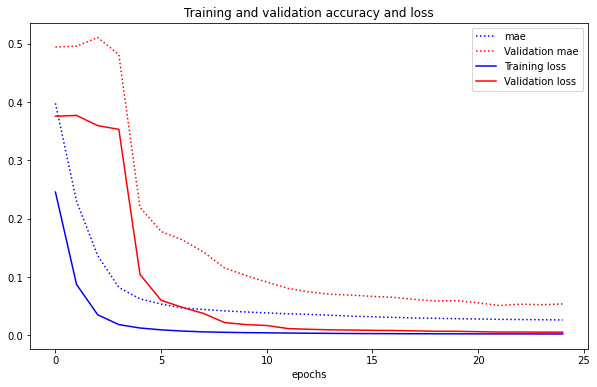

In [87]:
x=range(25)
loss = autoencoder_train.history['loss']
mae = autoencoder_train.history['mae']
val_mae = autoencoder_train.history['val_mae']
val_loss = autoencoder_train.history['val_loss']
plt.figure(figsize=(10,6))
plt.plot(x, mae, 'b:', label='mae')
plt.plot(x, val_mae, 'r:', label='Validation mae')
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.title('Training and validation accuracy and loss')
plt.xlabel('epochs')
plt.legend()
plt.show()


In [88]:
def get_error(imgs_true, imgs_pred):
    return np.sum(np.power(imgs_true - imgs_pred, 2))
    
          
train_pred = autoencoder.predict(train)
mse_vector=[]
mse_vector_test=[]
mse_vector_cont_test=[]
for i in range(train.shape[0]):
    mse_vector.append( get_error(train_pred[i], train[i]))

threshold = np.quantile(mse_vector, 0.90)

test_pred = autoencoder.predict(test)
cont_test_pred = autoencoder.predict(cont_test)
for i in range(test.shape[0]):
    mse_vector_test.append( get_error(test_pred[i], test[i]))
test_anomaly = (mse_vector_test > threshold)
print(test_anomaly)
for i in range(cont_test.shape[0]):
    mse_vector_cont_test.append( get_error(cont_test_pred[i], cont_test[i]))
cont_test_anomaly = (mse_vector_cont_test > threshold)
print('cont_test_anomaly',cont_test_anomaly)

[False False False False False False False  True False False False False
 False False  True  True False False False False False  True  True False
 False False False  True False  True False  True  True False  True False
  True False False False  True False False False  True False False False
  True  True False  True False False False  True False False  True  True
 False False  True  True  True False False False False False False False
  True False False  True  True  True  True  True  True False  True]
cont_test_anomaly [ True  True  True False False False False False False False  True False
 False  True  True  True  True  True  True False  True]


(array([37., 47., 34., 14., 11., 11.,  7.,  3.,  2.,  1.]),
 array([ 841.35626,  920.73706, 1000.11786, 1079.4987 , 1158.8795 ,
        1238.2603 , 1317.6411 , 1397.0219 , 1476.4027 , 1555.7834 ,
        1635.1643 ], dtype=float32),
 <a list of 10 Patch objects>)

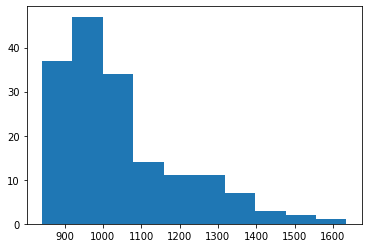

In [89]:
plt.hist(mse_vector)

(array([13., 19., 17.,  8., 10.,  7.,  6.,  1.,  1.,  1.]),
 array([ 861.59216,  981.17053, 1100.7489 , 1220.3273 , 1339.9056 ,
        1459.4839 , 1579.0623 , 1698.6406 , 1818.219  , 1937.7974 ,
        2057.3757 ], dtype=float32),
 <a list of 10 Patch objects>)

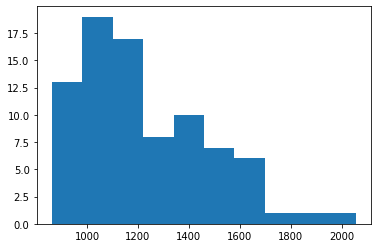

In [90]:
plt.hist(mse_vector_test)

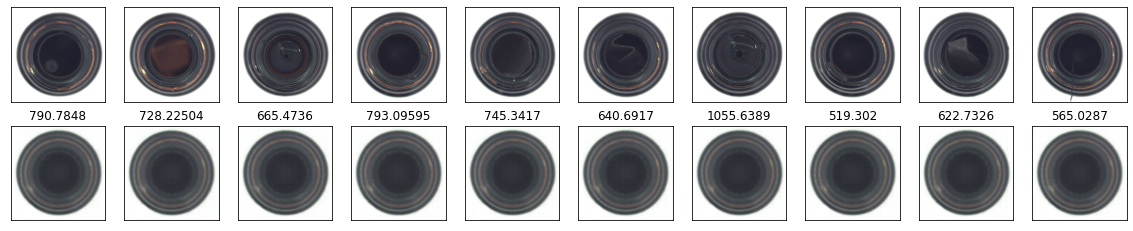

In [79]:

decoded_imgs = autoencoder.predict(cont_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(cont_test[i].reshape(256,256,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(256,256,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(get_error(decoded_imgs[i], test[i]))
plt.show()


In [91]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
print("Accuracy = {}".format(accuracy_score(test_labels, test_anomaly)))
print("Precision = {}".format(precision_score(test_labels, test_anomaly)))
print("Recall = {}".format(recall_score(test_labels, test_anomaly)))
print( classification_report(test_labels, test_anomaly))

Accuracy = 0.5301204819277109
Precision = 0.9
Recall = 0.42857142857142855
              precision    recall  f1-score   support

           0       0.32      0.85      0.47        20
           1       0.90      0.43      0.58        63

    accuracy                           0.53        83
   macro avg       0.61      0.64      0.52        83
weighted avg       0.76      0.53      0.55        83



In [92]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
print("Accuracy = {}".format(accuracy_score(cont_test_labels, cont_test_anomaly)))
print("Precision = {}".format(precision_score(cont_test_labels, cont_test_anomaly)))
print("Recall = {}".format(recall_score(cont_test_labels, cont_test_anomaly)))
print( classification_report(cont_test_labels, cont_test_anomaly))

Accuracy = 0.5238095238095238
Precision = 1.0
Recall = 0.5238095238095238
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.52      0.69        21

    accuracy                           0.52        21
   macro avg       0.50      0.26      0.34        21
weighted avg       1.00      0.52      0.69        21



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
